In [1]:
# Data manipulation and analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
# Natural Language Processing (NLP) libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Regular expressions and contractions handling
import re
import contractions
import string

# Set global configurations for visualizations
sns.set(style="whitegrid")


### Project: Sentiment Analysis for Mental Health
### Dataset: Sentiment Analysis for Mental Health (Kaggle)
### Task: Text Classification
### Objective: Analyze and classify mental health sentiments based on user text.

# Load and Explore the Dataset

In [2]:
data = pd.read_csv("Combined Data.csv")
data

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[53043 rows x 3 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
missing_summary = missing_values[missing_values > 0]
missing_summary

statement    362
dtype: int64

In [5]:
 # Check for duplicate rows
duplicates = data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")


Number of Duplicate Rows: 0


In [6]:
# Display unique classes in 'status'
print("Unique Classes in 'status':", data['status'].unique())


Unique Classes in 'status': ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


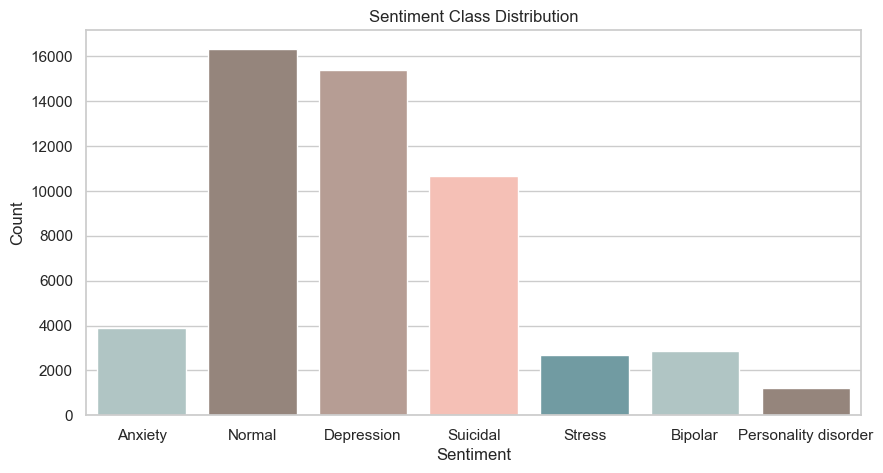

In [7]:
# Check class distribution for the 'status' column
custom_palette = ["#adc8c7", "#998478", "#bb9a8f", "#ffb9ac", "#69a1aa"]
plt.figure(figsize=(10, 5))
sns.countplot(x='status', data=data, palette=custom_palette)
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


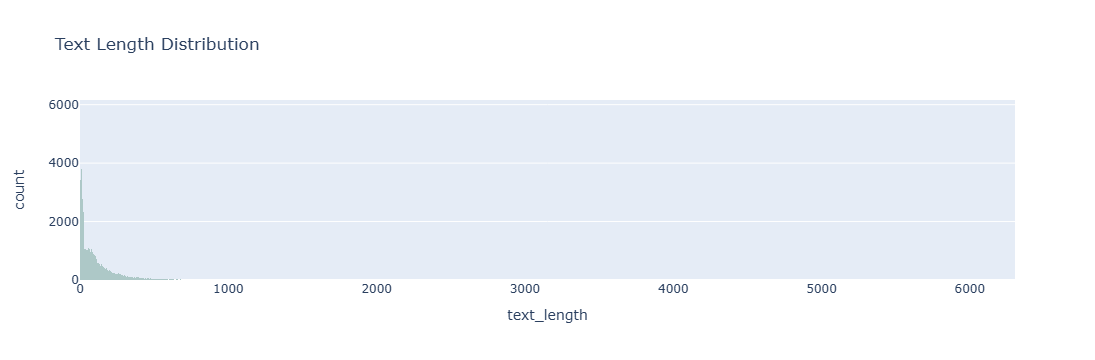

In [8]:
import plotly.express as px

# Assuming `data` is defined and contains a 'statement' column
data['text_length'] = data['statement'].apply(lambda x: len(str(x).split()))

# Custom color palette
custom_palette = ["#adc8c7", "#998478", "#bb9a8f", "#ffb9ac", "#69a1aa"]

# Create the histogram
fig = px.histogram(data, x='text_length', title='Text Length Distribution')

# Update the color of the bars
fig.update_traces(marker=dict(color=custom_palette[0]))  # Choose one color from the palette

# Show the figure
fig.show()


# Data Cleaning and Preprocessing

### Handle Missing Values

In [9]:
data['statement']=data['statement'].fillna('')

In [10]:
data

Unnamed: 0                                          statement   status  \
0               0                                         oh my gosh  Anxiety   
1               1  trouble sleeping, confused mind, restless hear...  Anxiety   
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3               3  I've shifted my focus to something else but I'...  Anxiety   
4               4  I'm restless and restless, it's been a month n...  Anxiety   
...           ...                                                ...      ...   
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety   
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety   
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety   
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety   
53042       53042  I have really bad door anxiety! It's not about...  Anxiety   

       text_length  
0                3  
1               10  
2               14  
3               11  
4               14  
...            ...  
53038          322  
53039          198  
53040           17  
53041           74  
53042           79  

[53043 rows x 4 columns]

In [11]:
# Drop unnecessary columns
data=data.drop(columns=['Unnamed: 0'], axis=1)

### Text Preprocessing

In [12]:
import pandas as pd
import re

def preprocess_text(text):
    if not isinstance(text, str):  # Check if the input is not a string
        return text  # Return as-is (can replace with an empty string if desired)
    text = text.lower()  
    text = re.sub(r'\[.*?\]', '', text)  
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = re.sub(r'<.*?>+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = re.sub(r'\w*\d\w*', '', text)  
    return text

# Example: Applying it to a DataFrame column
data['cleaned_statement'] = data['statement'].apply(preprocess_text)


In [13]:
# nltk.download('punkt')
# nltk.download('stopwords')

def tokenize_text(text):
    if not isinstance(text, str):  
        return []
    return word_tokenize(text.lower())  

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))  
    return [word for word in tokens if word not in stop_words]

def tokenization_stopwords(text):
    tokens = tokenize_text(text)  
    filtered_tokens = remove_stopwords(tokens)  
    return ' '.join(filtered_tokens)  


In [14]:
def augment_text(text):   
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')  
        return str(translated)
    except Exception as e:
        return text  

data['cleaned_statement'] = data['cleaned_statement'].apply(tokenization_stopwords)

data['augmented_statement'] = data['statement'].apply(augment_text)

augmented_df = data[['statement', 'status']].copy()
augmented_df['statement'] = data['augmented_statement']
data = pd.concat([data, augmented_df], ignore_index=True)

data['cleaned_statement'] = data['statement'].apply(tokenization_stopwords)

In [15]:
data['cleaned_statement'] = data['cleaned_statement'].fillna('')

In [16]:
data[['statement', 'cleaned_statement']].head()

statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                   cleaned_statement  
0                                            oh gosh  
1  trouble sleeping , confused mind , restless he...  
2  wrong , back dear , forward doubt . stay restl...  
3  've shifted focus something else 'm still worried  
4     'm restless restless , 's month , boy . mean ?

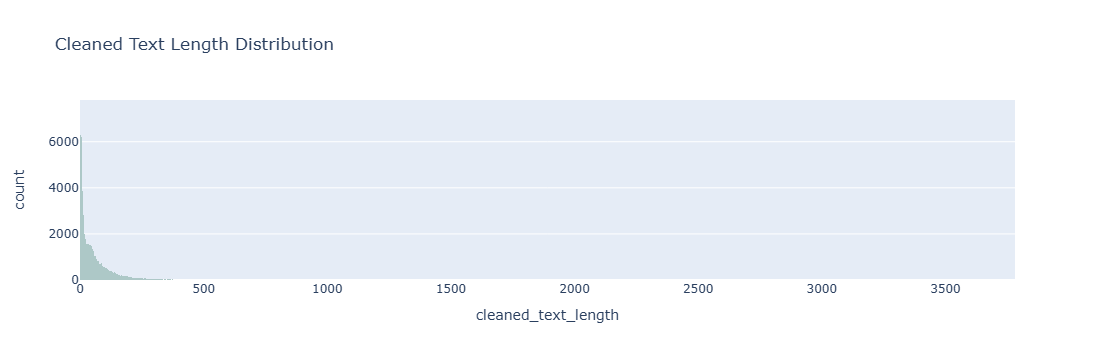

In [17]:
# Ensure `data['cleaned_statement']` is filled with empty strings for NaN values
data['cleaned_statement'] = data['cleaned_statement'].fillna('')

# Add a new column to count the text length of the cleaned text
data['cleaned_text_length'] = data['cleaned_statement'].apply(lambda x: len(str(x).split()))

# Custom color palette
custom_palette = ["#adc8c7", "#998478", "#bb9a8f", "#ffb9ac", "#69a1aa"]

# Create the histogram for cleaned text length
fig = px.histogram(data, x='cleaned_text_length', title='Cleaned Text Length Distribution')

# Update the color of the bars
fig.update_traces(marker=dict(color=custom_palette[0]))  # Choose one color from the palette

# Show the figure
fig.show()


### Text Visualization (Word Cloud)

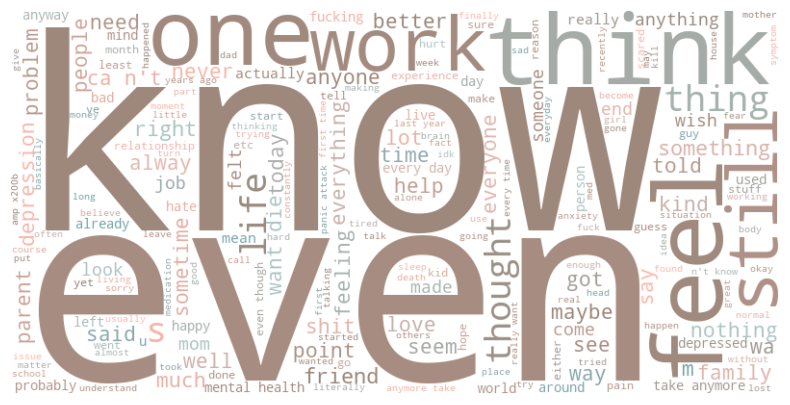

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Join all the text from the 'cleaned_statement' column
text = ' '.join(data['cleaned_statement'])

# Create a custom colormap from the palette
custom_palette = ["#adc8c7", "#998478", "#bb9a8f", "#ffb9ac", "#69a1aa"]
custom_cmap = LinearSegmentedColormap.from_list("custom_palette", custom_palette)

# Generate the WordCloud with the custom colormap
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap=custom_cmap
).generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [19]:
X = data['cleaned_statement']
y = data['status']

In [20]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

y_train_resampled_labels = label_encoder.inverse_transform(y_train_resampled)

from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))


Resampled class distribution: Counter({2: 26131, 5: 26131, 6: 26131, 3: 26131, 1: 26131, 4: 26131, 0: 26131})


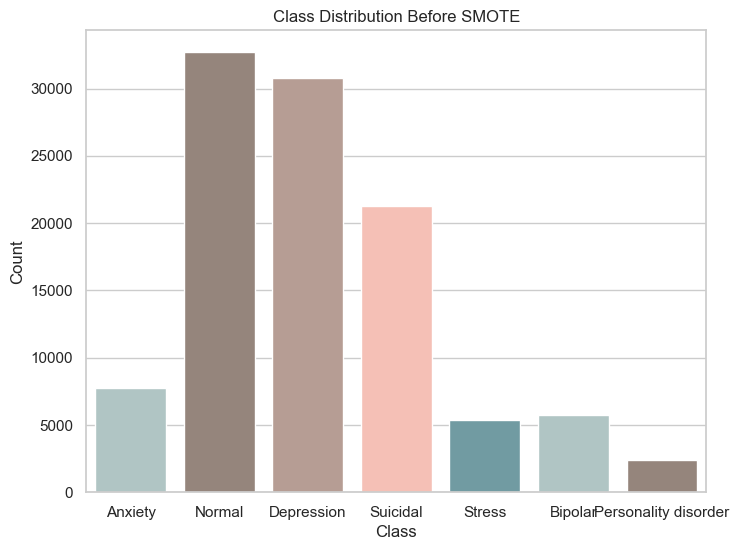

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette=custom_palette)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


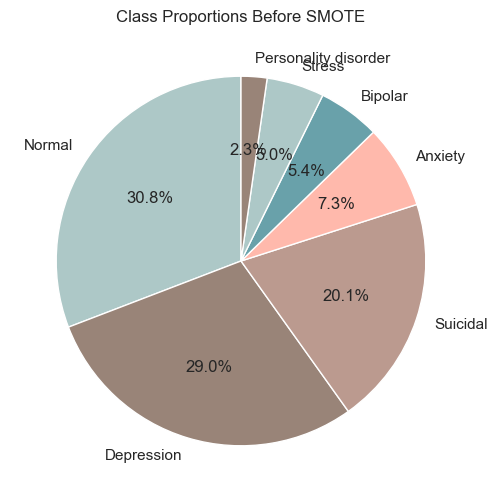

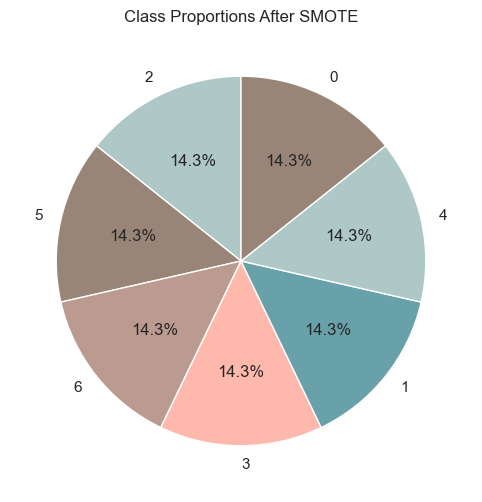

In [22]:
plt.figure(figsize=(8, 6))
y.value_counts().plot.pie(autopct="%1.1f%%", colors=custom_palette, startangle=90)
plt.title("Class Proportions Before SMOTE")
plt.ylabel("")  
plt.show()

plt.figure(figsize=(8, 6))
pd.Series(y_train_resampled).value_counts().plot.pie(autopct="%1.1f%%", colors=custom_palette, startangle=90)
plt.title("Class Proportions After SMOTE")
plt.ylabel("")  
plt.show()


# Logistic Regression

In [23]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the training set
y_train_pred = model.predict(X_train_resampled)
train_accuracy_LG = accuracy_score(y_train_resampled, y_train_pred)

# Make predictions on the test set
y_test_pred = model.predict(X_test_tfidf)
test_accuracy_LG = accuracy_score(y_test, y_test_pred)

# Evaluate the model's performance
print("\nLogistic Regression Model:")
print(f"Train Accuracy: {train_accuracy_LG:.4f}")
print(f"Test Accuracy: {test_accuracy_LG:.4f}")
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))



Logistic Regression Model:
Train Accuracy: 0.8290
Test Accuracy: 0.7592

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.74      0.88      0.80      1562
           1       0.72      0.85      0.78      1150
           2       0.81      0.67      0.73      6182
           3       0.91      0.80      0.85      6571
           4       0.41      0.82      0.55       447
           5       0.50      0.72      0.59      1047
           6       0.69      0.75      0.72      4259

    accuracy                           0.76     21218
   macro avg       0.68      0.79      0.72     21218
weighted avg       0.78      0.76      0.76     21218



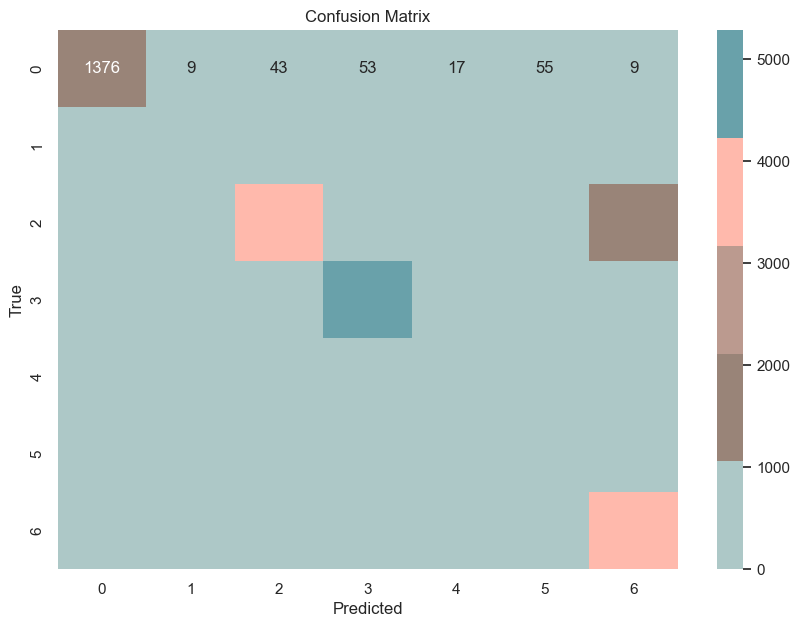

In [24]:
# Generate and display a confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap=custom_palette, xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

 

MultinomialNB()

In [26]:
# Train Accuracy
y_train_pred = nb_model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

# Test Accuracy
y_pred = nb_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print("\nNaive Bayes Model:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred))



Naive Bayes Model:
Train Accuracy: 0.7558
Test Accuracy: 0.6572

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.53      0.80      0.64      1562
           1       0.53      0.78      0.63      1150
           2       0.74      0.56      0.64      6182
           3       0.93      0.63      0.75      6571
           4       0.28      0.77      0.41       447
           5       0.42      0.59      0.49      1047
           6       0.61      0.76      0.67      4259

    accuracy                           0.66     21218
   macro avg       0.58      0.70      0.60     21218
weighted avg       0.72      0.66      0.67     21218



# Decission Tree

In [27]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

y_pred_dt = dt_model.predict(X_test_tfidf)
print("\nDecision Tree Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(classification_report(y_test, y_pred_dt))


Decision Tree Model:
Accuracy: 0.9038
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1562
           1       0.91      0.89      0.90      1150
           2       0.92      0.90      0.91      6182
           3       0.96      0.92      0.94      6571
           4       0.48      0.95      0.63       447
           5       0.84      0.86      0.85      1047
           6       0.89      0.90      0.89      4259

    accuracy                           0.90     21218
   macro avg       0.84      0.90      0.86     21218
weighted avg       0.91      0.90      0.91     21218



In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Train Accuracy
y_train_pred_dt = dt_model.predict(X_train_resampled)
train_accuracy_dt = accuracy_score(y_train_resampled, y_train_pred_dt)

# Test Accuracy
test_accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Print results
print("\nDecision Tree Model:")
print(f"Train Accuracy: {train_accuracy_dt:.4f}")
print(f"Test Accuracy: {test_accuracy_dt:.4f}")
print(classification_report(y_test, y_pred_dt))



Decision Tree Model:
Train Accuracy: 0.9831
Test Accuracy: 0.9038
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1562
           1       0.91      0.89      0.90      1150
           2       0.92      0.90      0.91      6182
           3       0.96      0.92      0.94      6571
           4       0.48      0.95      0.63       447
           5       0.84      0.86      0.85      1047
           6       0.89      0.90      0.89      4259

    accuracy                           0.90     21218
   macro avg       0.84      0.90      0.86     21218
weighted avg       0.91      0.90      0.91     21218



# Random Forect

In [29]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy on training data
y_train_pred_rf = rf_model.predict(X_train_resampled)
train_accuracy_rf = accuracy_score(y_train_resampled, y_train_pred_rf)
y_pred_rf = rf_model.predict(X_test_tfidf)
# Print results
print("\nRandom Forest Model:")
print(f"Train Accuracy: {train_accuracy_rf:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))



Random Forest Model:
Train Accuracy: 0.9831
Test Accuracy: 0.9294
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1562
           1       0.98      0.91      0.94      1150
           2       0.92      0.94      0.93      6182
           3       0.97      0.94      0.95      6571
           4       0.52      0.94      0.67       447
           5       0.98      0.86      0.92      1047
           6       0.92      0.92      0.92      4259

    accuracy                           0.93     21218
   macro avg       0.89      0.92      0.90     21218
weighted avg       0.94      0.93      0.93     21218



# NN

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import numpy as np

# Define the model
model = Sequential()

# Add an input layer with the same number of neurons as features
model.add(Input(shape=(X_train_resampled.shape[1],)))  # Better practice
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Add output layer with softmax activation (multi-class classification)
model.add(Dense(len(np.unique(y_train_resampled)), activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Or use 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduce learning rate on plateau to fine-tune the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_tfidf, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on training data
train_predictions = model.predict(X_train_resampled)
train_predictions = train_predictions.argmax(axis=1)
train_accuracy = accuracy_score(y_train_resampled, train_predictions)

# Evaluate the model on test data
test_predictions = model.predict(X_test_tfidf)
test_predictions = test_predictions.argmax(axis=1)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - accuracy: 0.3240 - loss: 1.5557 - val_accuracy: 0.6403 - val_loss: 0.8717 - learning_rate: 0.0010
Epoch 2/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - accuracy: 0.6343 - loss: 0.8473 - val_accuracy: 0.7268 - val_loss: 0.7249 - learning_rate: 0.0010
Epoch 3/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.7663 - loss: 0.6023 - val_accuracy: 0.7632 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 4/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - accuracy: 0.8047 - loss: 0.5119 - val_accuracy: 0.7950 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 5/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.8334 - loss: 0.4565 - val_accuracy: 0.8069 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 6/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - accuracy: 0.8537 - loss: 0.4180 - val_accuracy: 0.8204 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 7/50
5717/5717 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accura

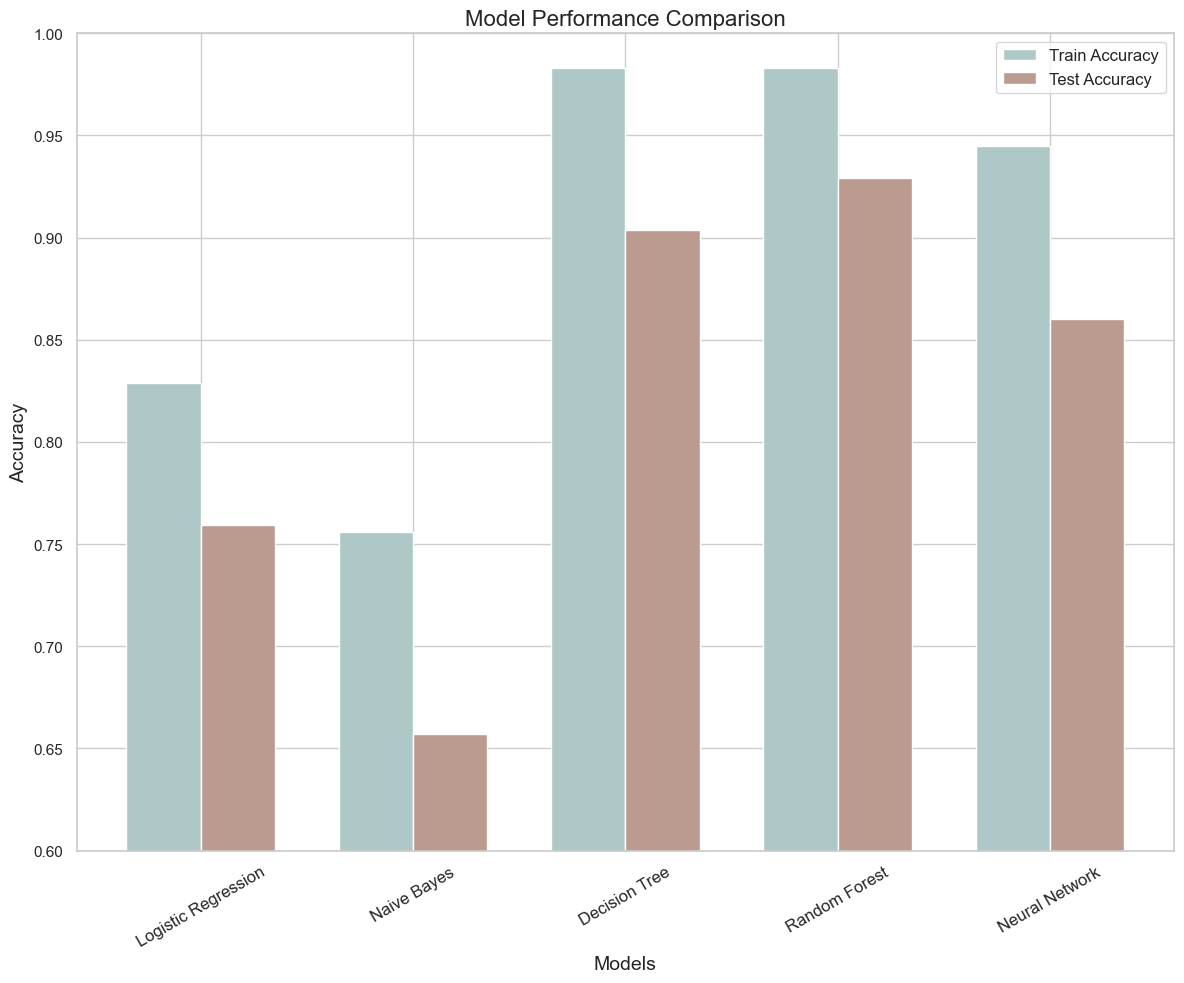

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Model names, accuracies for training and testing
models = [
    "Logistic Regression",
    "Naive Bayes",
    "Decision Tree",
    "Random Forest",
    "Neural Network"
]
custom_palette = ["#adc8c7", "#998478", "#bb9a8f", "#ffb9ac", "#69a1aa"]

# Define accuracies for each model
train_accuracies = [
    0.8290,  # Logistic Regression
    0.7558,  # Naive Bayes
    0.9831,  # Decision Tree
    0.9831,  # Random Forest
    0.9449   # Neural Network
]

test_accuracies = [
    0.7592,  # Logistic Regression
    0.6572,  # Naive Bayes
    0.9038,  # Decision Tree
    0.9294,  # Random Forest
    0.8604   # Neural Network
]

# Visualize results
x = np.arange(len(models))  # Model indices
width = 0.35  # Bar width

plt.figure(figsize=(12, 10))

# Plot training and testing accuracies
plt.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='#adc8c7')
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='#bb9a8f')

# Add plot details
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(x, models, rotation=30, fontsize=12)
plt.ylim(0.60, 1.0)  # Set y-axis range starting at 0.60
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
